In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive

/content/drive/My Drive


In [0]:
import pandas as pd

In [0]:
data = pd.read_csv('data.csv', error_bad_lines=False)

In [0]:
data = data.sample(frac=1)
data.head(5)

,Unnamed: 0,text,label
1111,1111,best rotary engine,4
1126,1126,transmission fluid,4
126,126,organization halt,2
397,397,price differential compare different model,1
586,586,rear pad fully sweep disc,4


In [0]:
data = data.drop(['Unnamed: 0'], axis = 1)

In [0]:
data.head()

,text,label
1111,best rotary engine,4
1126,transmission fluid,4
126,organization halt,2
397,price differential compare different model,1
586,rear pad fully sweep disc,4


In [0]:
data.describe()

,label
count,1491.000000
mean,2.397049
std,1.620537
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,4.000000


In [0]:
len(data)

1491

In [0]:
!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 133kB 50.8MB/s 
     |████████████████████████████████| 92kB 42.3MB/s 
     |████████████████████████████████| 655kB 53.1MB/s 
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609248 sha256=e8699664165a8ed74ec5c850889291176b8f9805b4c5e6981c6ac914f017625c
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built regex


In [0]:
%matplotlib inline
import sys
import itertools
import numpy as np
import random as rn
import matplotlib.pyplot as plt
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
from torchnlp.datasets import imdb_dataset
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

Using TensorFlow backend.


In [0]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Prepare the Data

In [0]:
data = data.sample(frac=1)
train_data_full, test_data_full = (data[:1000], data[1000:])
train_data = train_data_full
test_data = test_data_full
train_data.head()

,text,label
1275,idea look,0
1030,ram transmission,4
222,glad hear honor customer like share picture vi...,3
281,motor distributor mess ask part available sinc...,3
845,stay toyota tacoma road anything reset turn,4


In [0]:
train_texts, train_labels = (train_data['text'], train_data['label'])
test_texts, test_labels = (test_data['text'], test_data['label'])

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(1000, 1000, 491, 491)

In [0]:
train_texts.head()

1275                                            idea look
1030                                     ram transmission
222     glad hear honor customer like share picture vi...
281     motor distributor mess ask part available sinc...
845           stay toyota tacoma road anything reset turn
Name: text, dtype: object

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 513294.94B/s]


In [0]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(str(t))[:127], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(str(t))[:127], test_texts))

len(train_tokens), len(test_tokens)          

(1000, 491)

In [0]:
test_tokens[490]

['[CLS]', 'tau', '##rus', 'weird', 'sound', 'come']

In [0]:
train_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens))
test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))

In [0]:
train_tokens_ids = pad_sequences(train_tokens_ids, maxlen=128, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(test_tokens_ids, maxlen=128, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((1000, 128), (491, 128))

In [0]:
train_labels.head()

1275    0
1030    4
222     3
281     3
845     4
Name: label, dtype: int64

In [0]:
train_y = np.array(train_labels)
test_y = np.array(test_labels)
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((1000,), (491,), 2.395, 2.4012219959266803)

In [0]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [0]:
np.count_nonzero(np.isnan(train_labels))

0

# Baseline

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [0]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts.astype('U'), train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
baseline_predicted = baseline_model.predict(test_texts.astype('U'))

In [0]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

           0       0.66      0.65      0.65       102
           1       0.67      0.46      0.54        68
           2       0.86      0.41      0.56        58
           3       0.97      0.61      0.75        57
           4       0.69      0.95      0.80       206

    accuracy                           0.71       491
   macro avg       0.77      0.62      0.66       491
weighted avg       0.74      0.71      0.70       491



# BERT model

In [0]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(768, 1)
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        linear_output = self.linear(pooled_output)
        return linear_output

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
bert_clf = BertClassifier()
bert_clf = bert_clf.cuda()


100%|██████████| 407873900/407873900 [00:28<00:00, 14336598.97B/s]


In [0]:
BATCH_SIZE = 4
EPOCHS = 3

In [0]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1))

test_tokens_tensor = torch.tensor(test_tokens_ids).float()
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks).float()

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'12101.384192M'

In [0]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)


In [0]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [0]:

loss_func = nn.CrossEntropyLoss()

In [0]:
losses = []
steps = []
step = 0
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        print(batch_data)
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        probas = bert_clf(token_ids, masks)
        
        batch_loss = loss_func(probas, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))
        losses.append(batch_loss.item())
        steps.append(step)
        step += 1

[tensor([[  101,  2054,  2015,  ...,     0,     0,     0],
        [  101,  2132,  3131,  ...,     0,     0,     0],
        [  101,  2052,  2066,  ...,     0,     0,     0],
        ...,
        [  101,  2800,     0,  ...,     0,     0,     0],
        [  101,  3073,  2204,  ...,     0,     0,     0],
        [  101, 10539,  2131,  ...,     0,     0,     0]]), tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]]), tensor([[2],
        [4],
        [0],
        [0],
        [4],
        [0],
        [4],
        [3],
        [3],
        [1],
        [4],
        [1],
        [2],
        [0],
        [3],
        [0]])]


RuntimeError: ignored

In [0]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

In [0]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        probas = bert_clf(token_ids, masks)
        numpy_probas = probas.cpu().detach().numpy()
        
        bert_predicted += list(sigmoid(numpy_probas[:, 0]) > 0.5)

In [0]:
test_y[:5], bert_predicted[:5]

(array([4, 4, 0, 4, 2]), [True, True, True, True, True])

In [0]:
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.16      1.00      0.28        16
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        39

    accuracy                           0.16       100
   macro avg       0.03      0.20      0.06       100
weighted avg       0.03      0.16      0.04       100



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Distilling BERT

In [0]:
train_dataset_for_distill = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_dataloader_for_distill = DataLoader(train_dataset, batch_size=BATCH_SIZE)

In [0]:
bert_clf.eval()
train_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(train_dataloader_for_distill):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()
        
        train_logits.append(numpy_logits)
train_logits = np.vstack(train_logits)

In [0]:
print(classification_report(train_y, sigmoid(train_logits[:, 0]) > 0.5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       106
           1       0.12      1.00      0.22        62
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00        72
           4       0.00      0.00      0.00       206

    accuracy                           0.12       500
   macro avg       0.02      0.20      0.04       500
weighted avg       0.02      0.12      0.03       500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
distilled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(train_texts.astype('U'), train_logits)

In [0]:
distilled_predicted_logits = distilled_model.predict(test_texts.astype('U'))

In [0]:
print(classification_report(test_y, sigmoid(distilled_predicted_logits[:, 0]) > 0.5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.16      1.00      0.28        16
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        39

    accuracy                           0.16       100
   macro avg       0.03      0.20      0.06       100
weighted avg       0.03      0.16      0.04       100



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([  1.,   3.,   0.,   0.,   0.,   1.,   9.,  35., 125., 326.]),
 array([7.247724 , 7.2871833, 7.3266425, 7.3661017, 7.405561 , 7.4450197,
        7.484479 , 7.523938 , 7.5633974, 7.6028566, 7.642316 ],
       dtype=float32),
 <a list of 10 Patch objects>)

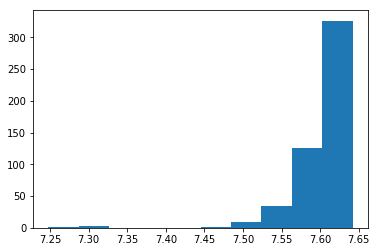

In [0]:
plt.hist(train_logits)

In [0]:
unlabeled_data = train_data_full[1000:6000]

In [0]:
unlabeled_texts, _ = (test)

TypeError: ignored

In [0]:
unlabeled_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], unlabeled_texts))

In [0]:
unlabeled_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, unlabeled_tokens))

In [0]:
unlabeled_tokens_ids = pad_sequences(unlabeled_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
unlabeled_tokens_ids.shape

In [0]:
unlabeled_masks = [[float(i > 0) for i in ii] for ii in unlabeled_tokens_ids]

In [0]:
unlabeled_tokens_tensor = torch.tensor(unlabeled_tokens_ids)
unlabeled_masks_tensor = torch.tensor(unlabeled_masks)

In [0]:
unlabeled_dataset = TensorDataset(unlabeled_tokens_tensor, unlabeled_masks_tensor)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE)

In [0]:
bert_clf.eval()
unlabeled_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(unlabeled_dataloader):

        token_ids, masks = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()
        
        unlabeled_logits.append(numpy_logits)
        clear_output(wait=True)
        print("{0}/{1}".format(step_num, len(unlabeled_data) / BATCH_SIZE))
unlabeled_logits = np.vstack(unlabeled_logits)

In [0]:
unlabeled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(unlabeled_texts, unlabeled_logits)

In [0]:
unlabele_predicted_logits = unlabeled_model.predict(test_texts)

In [0]:
print(classification_report(test_y, sigmoid(unlabele_predicted_logits[:, 0]) > 0.5))